In [2]:
# Set the real field to be used to approximate numbers
prec = 60
RR = RealField(prec)

In [3]:
# I will use the FHP form of the curve
# Pick a value of beta
beta = -1/2

# Give the numerical value of the associated parameter B
B_RR = RR(elliptic_kc(2*beta/(1+beta))^2/(1+beta))
print(B_RR)

2.7444500270848508


In [5]:
# beta_tilde = sqrt(-beta^(-1) + sqrt(beta^(-2) - 1))
# RR(beta_tilde)

In [6]:
# We will want to approximate B with a rational to use Sage. 
den = 3
r = B_RR/den

# Copied from https://www.johndcook.com/blog/2010/10/20/best-rational-approximation/
def farey(x, N):
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c, d
            else:
                return a, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d

    if (b > N):
        return c, d
    else:
        return a, b

# Set a maximum numerator / denominator size
N = 300  
# c/d then approximates r
c, d = farey(r, N)
print(c, d)
print((RR(c/d) - r).abs())

247 270
1.8608801354352486e-6


In [7]:
# Create now the spectral curve
K.<j> = QQ.extension(polygen(QQ)^2 + 1, embedding=I)
R.<x,y> = K[]

k = 2

# For FHP curve
B = den*c/d
A = beta*B/2
f = y^2 + A*(x^4 + 1) + B*x^2

from sage.schemes.riemann_surfaces.riemann_surface import RiemannSurface

# The differentials are chosen here like Klein and Kalla so omega^tau = omega
S = RiemannSurface(f, differentials=[j])
S

Riemann surface defined by polynomial f = -247/360*x^4 + 247/90*x^2 + y^2 - 247/360 = 0, with 53 bits of precision

In [8]:
# Construct the ES vector using matrix inversion. 

# Make the vector v such that Omega*ES = v, where Omega is the period matrix. 
CB = S.cohomology_basis()
beta0s = [di.coefficient({x:0, y:k-2}) for di in CB]
g = S.genus
v = matrix(g, 1, [-2*CC(beta0) for beta0 in beta0s])
v_conjugate = matrix(g, 1, [z.conjugate() for z in v])

# Get the period matrix
PM = S.period_matrix()
PM_conjugate = matrix(g, 2*g, [z.conjugate() for z in PM.list()])

M = block_matrix([[PM], [PM_conjugate]])
V = block_matrix([[v], [v_conjugate]])

# Get the ES using inversion
from sage.schemes.riemann_surfaces.riemann_surface import numerical_inverse
ES = numerical_inverse(M)*V
ES

[   0.999998982921316]
[2.02989881330222e-17]

In [9]:
# Take the nearest integer vector to the numerical ES, and check the precision. 
def matrix_ZZ(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.real().round(), M.list()))

def absolute_rounding_error(M):
    return max(ei.abs() for ei in (M-matrix_ZZ(M)).list())

ES_ZZ = matrix_ZZ(ES)
print(absolute_rounding_error(ES))

ES_ZZ = vector(ES_ZZ)
ES_ZZ

1.01707868427336e-6


In [11]:
# Construct now the action of tau on the homology basis using Kalla and Klein. 
PAbar, PBbar = PM[:, :g].transpose(), PM[:, g:].transpose()

def matrix_imag(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.imag(), M.list()))

def matrix_real(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.real(), M.list()))

# Eqn 25
Mt = matrix_imag(PBbar.transpose())*matrix_real(PAbar) - matrix_imag(PAbar.transpose())*matrix_real(PBbar)
Mti = numerical_inverse(Mt)

# Eqn 24
KKR = block_matrix([[(2*matrix_real(PBbar)*Mti*matrix_imag(PAbar.transpose()) + matrix.identity(g)).transpose(),
                    -2*matrix_real(PAbar)*Mti*matrix_imag(PAbar.transpose())],
                   [2*matrix_real(PBbar)*Mti*matrix_imag(PBbar.transpose()),
                   -(2*matrix_real(PBbar)*Mti*matrix_imag(PAbar.transpose()) + matrix.identity(g))]])

# Convert to an integer matrix and check the precision
KKR_ZZ = matrix_ZZ(KKR)
print(absolute_rounding_error(KKR))
print(KKR_ZZ)

4.05980175574227e-17
[-1  0]
[ 0  1]


In [12]:
# Check that ES is antiinvariant under tau
not any(KKR_ZZ.transpose()*ES_ZZ + ES_ZZ)

True

We now want to compare the found ES cycle to a lift of equators. 

()


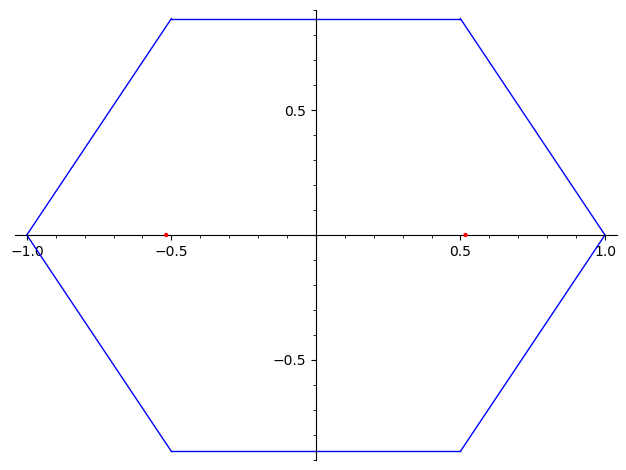

In [13]:
# First compute the monodromy of the equator and confirm it is trivial

ng = 6
vertices = [exp(2*k*S._CC(pi*sqrt(-1))/ng) for k in range(ng)]
downstairs_edges = [(i, i+1) for i in range(ng-1)] + [(0, ng-1)]

wvalues = [S.w_values(zi) for zi in vertices]

###
# UPSTARIS_EDGES
###
L = {}
edgeset = []
n = len(S._wvalues[0])
# Lifts each edge individually.
for e in downstairs_edges:
    i0, i1 = e
    d_edge = (vertices[i0], vertices[i1])
    # Epsilon for checking w-value later.
    epsilon = min([abs(wvalues[i1][i] - wvalues[i1][n-j-1]) 
                   for i in range(n) for j in range(n-i-1)])/3
    # Homotopy continuation along e.
    L[e] = S.homotopy_continuation(d_edge)
    homotopycont = L[e][-1][1]
    for i in range(len(homotopycont)):
        # Checks over the w-values of the next point to check which it is.
        for j in range(len(wvalues[i1])):
            if abs(homotopycont[i] - wvalues[i1][j]) < epsilon:
                # Once it finds the appropriate w-value, adds the edge.
                edgeset = edgeset + [[(i0, i), (i1, j)]]
                continue
upstairs_edges = edgeset

###
# EDGE_PERMUTATIONS
###

def edge_permutation(edge):
    if edge in downstairs_edges:
        # find all upstairs edges that are lifts of the given
        # downstairs edge and store the corresponding indices at
        # start and end that label the branches upstairs.
        L = [(j0, j1) for ((i0, j0), (i1, j1)) in upstairs_edges
             if edge == (i0, i1)]
        # we should be finding exactly "degree" of these
        assert len(L) == S.degree
        # and as a corollary of how we construct them, the indices
        # at the start should be in order
        assert all(a == b[0] for a, b in enumerate(L))
        return S._Sn([j1 for j0, j1 in L])
    raise ValueError('edge not in polygon')
    
D = {e: edge_permutation(e) for e in downstairs_edges}
for (a, b), p in list(D.items()):
    D[(b, a)] = p**(-1)
edge_permutations = D

###
# FINAL RESULT
###

equator_monodromy = prod(edge_permutations[(i, (i+1)%ng)] 
                         for i in range(ng))
print("Monodromy around equator:", equator_monodromy)

point2d([bi for bi in S.branch_locus if bi.abs()<=1], 
        color='red', zorder=200) + sum([line((vertices[i0], vertices[i1])) 
                            for i0, i1 in downstairs_edges])

Finally I will check that the ES cycle is in the subspace of $H_1(\mathcal{C}, \mathbb{Q})$ generated by lifts of the equator

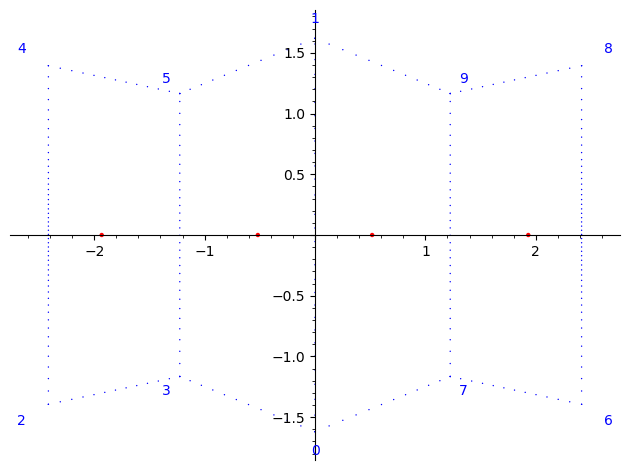

[[(0, 0), (1, 0)],
 [(0, 1), (1, 1)],
 [(0, 0), (3, 0)],
 [(0, 1), (3, 1)],
 [(0, 0), (7, 0)],
 [(0, 1), (7, 1)],
 [(1, 0), (5, 0)],
 [(1, 1), (5, 1)],
 [(1, 0), (9, 0)],
 [(1, 1), (9, 1)],
 [(2, 0), (3, 1)],
 [(2, 1), (3, 0)],
 [(2, 0), (4, 0)],
 [(2, 1), (4, 1)],
 [(3, 0), (5, 1)],
 [(3, 1), (5, 0)],
 [(4, 0), (5, 1)],
 [(4, 1), (5, 0)],
 [(6, 0), (7, 1)],
 [(6, 1), (7, 0)],
 [(6, 0), (8, 0)],
 [(6, 1), (8, 1)],
 [(7, 0), (9, 1)],
 [(7, 1), (9, 0)],
 [(8, 0), (9, 1)],
 [(8, 1), (9, 0)]]

In [15]:
# Now plot the paths Sage uses internally, labelling the vertices, and print the upstairs edges
P = []
for e in S._L.keys():
    z0 = S._vertices[e[0]]
    z1 = S._vertices[e[1]]

    def path(t):
        return (1 - t) * z0 + t * z1
    T = S._L[e]
    P += [path(t[0]) for t in T]
    
PT = point2d(P, size=1) + point2d(S.branch_locus, color="red") + sum([text("{}".format(i), 1.1*S._vertices[i]) 
                                                                    for i in range(len(S._vertices))])
PT.show()

S.upstairs_edges()

In [16]:
# Write down the two lifts of the equator
e0 = [(9, 0), (1, 0), (5, 0), (3, 1), (0, 1), (7, 1)]
e1 = [(9, 1), (1, 1), (5, 1), (3, 0), (0, 0), (7, 0)]

# Compute their intersections with the cycle basis computed by Sage
def intersection_with_basis(cycle):
    cycles = S.upstairs_graph().cycle_basis()
    # Computing the Gram matrix.
    cn = len(cycles)
    
    direction_cache = {}
    def direction(center, neighbour):
        k = (center, neighbour)
        if k not in direction_cache:
            theta = (S._vertices[neighbour] - S._vertices[center]).argument()
            direction_cache[k] = theta
            return theta
        else:
            return direction_cache[k]
    
    intersections = []
    for j in range(len(cycles)):
        # Initializing the intersection product value.
        intsum = 0
        # Intersection of the edges
        intsec = set(cycle).intersection(set(cycles[j]))
        for v in intsec:
            # Get indices of the vertex in the cycles.
            i0 = cycle.index(v)
            i1 = cycles[j].index(v)
            # Get the complex value of the vertex v.
            center = cycle[i0][0]

            # We are in the following situation:
            # We have two paths a_in->v->a_out and
            # b_in->v->b_out intersecting. We say they
            # are "positively oriented" if the a-path
            # and the b-path are oriented as the x and y axes, i.e.,
            # if, when we walk around v in counter-clockwise direction,
            # we encounter a_in,b_in,a_out,b_out.

            # we can also have that b_in and/or b_out overlaps with
            # a_in and/or a_out. If we just score the orientation of
            # b_in and b_out individually, we can deal with this
            # by just ignoring the overlapping vertex. The "half"
            # score will be appropriately complemented at one of the
            # next vertices.

            a_in = cycle[i0-1][0]
            a_out = cycle[(i0+1) % len(cycle)][0]
            b_in = cycles[j][i1-1][0]
            b_out = cycles[j][(i1+1) % len(cycles[j])][0]

            # we can get the angles (and hence the rotation order)
            # by taking the arguments of the differences.

            a_in_arg = direction(center, a_in)
            a_out_arg = direction(center, a_out)
            b_in_arg = direction(center, b_in)
            b_out_arg = direction(center, b_out)

            # we make sure to test overlap on the indices, so no rounding
            # problems occur with that.

            if (b_in != a_in) and (b_in != a_out):
                if ((a_in_arg < b_in_arg < a_out_arg)
                    or (b_in_arg < a_out_arg < a_in_arg)
                    or (a_out_arg < a_in_arg < b_in_arg)):
                    intsum += 1
                elif ((a_out_arg < b_in_arg < a_in_arg)
                      or (b_in_arg < a_in_arg < a_out_arg)
                      or (a_in_arg < a_out_arg < b_in_arg)):
                    intsum -= 1
                else:
                    raise RuntimeError("impossible edge orientation")
            if (b_out != a_in) and (b_out != a_out):
                if ((a_in_arg < b_out_arg < a_out_arg)
                    or (b_out_arg < a_out_arg < a_in_arg)
                    or (a_out_arg < a_in_arg < b_out_arg)):
                    intsum -= 1
                elif ((a_out_arg < b_out_arg < a_in_arg)
                      or (b_out_arg < a_in_arg < a_out_arg)
                      or (a_in_arg < a_out_arg < b_out_arg)):
                    intsum += 1
                else:
                    raise RuntimeError("impossible edge orientation")
        assert (intsum % 2) == 0
        intsum = intsum // 2
        intersections.append(intsum)
    return vector(intersections)

I0, I1 = intersection_with_basis(e0), intersection_with_basis(e1)

print(I0)
print(I1)

(0, -1, 0, 0, 1, 0, -1)
(0, 1, 0, 0, -1, 0, 1)


In [17]:
# Compute the intersection of the ES cycle with the basis of Sage
vs = []
for ci in S.homology_basis():
    v = 0*I0
    for ni, loopi in ci:
        v += ni*intersection_with_basis(loopi[:-1])
    vs.append(v)

es = sum(ni*vi for ni, vi in zip(ES_ZZ, vs))
es

(0, 1, 0, 0, -1, 0, 1)

In [19]:
# Test if the ES cycle is in the subspace of H1(C, ZZ) generated by equators.  
V = VectorSpace(QQ, len(vs[0]))
W = V.subspace_with_basis(vs)
E0, E1 = W.coordinates(I0), W.coordinates(I1)

V = VectorSpace(QQ, 2*S.genus)
W = V.subspace([vector(Ei) for Ei in [E0, E1]])

vector(ES_ZZ) in W

True